## try out pytorch
We're going to try out pytorch to do some machine learning

TODO: remove NaN rows in the dataset. How do we do that


In [118]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler
from matplotlib import pyplot as plt
import torch.nn as nn

import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import r2_score
    
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [179]:
class DryBeanDataset(Dataset):
    
    def __init__(self):
        # data loading
        #crop-yield-prediction-rs/Bean_Othello_Jul21_M10_transparent_reflectance_hyperindices.csv
        # import it as a pandas dataframe, slice it and change it to numpy array, 

        xy = pd.read_csv('Bean_Othello_Jul21_M10_transparent_reflectance_hyperindices.csv', skiprows = 1, header=None).iloc[:, 10:]
        xy_np = xy.to_numpy().astype(np.float32)
        
        # scale all of our predictors
#         min_max_scaler = preprocessing.MinMaxScaler()
#         self.scalerX = preprocessing.MinMaxScaler().fit(xy_np[:,1:])
#         self.scalerY = preprocessing.MinMaxScaler().fit(xy_np[:,0].reshape(-1, 1))
        self.scalerX = StandardScaler().fit(xy_np[:,1:])
        self.scalerY = StandardScaler().fit(xy_np[:,0].reshape(-1, 1))
        
        x_scaled = self.scalerX.fit_transform(xy_np[:,1:])
        y_scaled = self.scalerY.fit_transform(xy_np[:,0].reshape(-1, 1))

        self.x = torch.from_numpy(x_scaled) #gets all the index means
        self.y = torch.from_numpy(y_scaled) # yield data
        
        #self.x = torch.from_numpy(xy.iloc[:, 12:].to_numpy().astype(np.float32)) #gets all the index means
        #self.y = torch.from_numpy(xy[:,11]) # 100 seed weight
        #self.y = torch.from_numpy(xy.iloc[:, 10].to_numpy().astype(np.float32)) # yield data
        #self.y = torch.from_numpy(xy[:, 9]) # harvest maturity
        #self.y = torch.from_numpy(xy[:, 8]) # emergence
        self.n_samples = self.y.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
    
    def inverse_scalery(self, y_new):
        # use this to inverse transform at the end
        y_new_inverse = self.scalerY.inverse_transform(y_new)
        return y_new_inverse
    
    
# create dataset
dataset = DryBeanDataset()
# print(dataset.n_samples)
# df = dataset.pd_df
# df.head()

# sns.countplot(x = 'kgha', data=df)

In [180]:

batch_size = 1
test_split = .2
shuffle_dataset = True
random_seed = 26

# Creating data indices for training and testing splits:
dataset_size = len(dataset)
print(dataset_size)

indices = list(range(dataset_size))

split = int(np.floor(test_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=test_sampler)



116


In [201]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, 1)
        self.loss_values = []
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out
    
    def train_model(self, trainloader, num_epochs):
        print("training")

        for epoch in range(num_epochs):
            for x,y in trainloader:
#                 x = x.reshape(-1, 90)
                
                # forward pass
                y_predicted = model(x)

                # track our loss
                loss = criterion(y_predicted, y)
                loss_values.append(loss.item())

                # zero our gradients 
                optimizer.zero_grad()

                # backward pass
                loss.backward()

                # update
                optimizer.step()

            if (epoch+1) % 10 == 0:
                print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')
                
def make_pred(model, test_loader):
        pred = []
        real = []
        
        for i, (x,y) in enumerate(test_loader):
            real_yield = y.item()
            pred_yield = model(x).item()
            print(i, real_yield, pred_yield)

            pred.append(pred_yield)
            real.append(real_yield)


        pred = np.asarray(pred)
        real = np.asarray(real)

        r_squared = r2_score(real, pred)
        print(r_squared)

# NN linear model in pytorch parameters
input_size = 91
hidden_size = 91
output_size = 1
learning_rate = 0.01

num_epochs = 1000
loss_values = []

# instantiate the model
model = NeuralNet(input_size, hidden_size)

# loss and optimization functions
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# call the training functionf
model.train_model(train_loader, num_epochs)

# test the model
make_pred(model, test_loader)



training
epoch: 10, loss = 0.9002
epoch: 20, loss = 0.2144
epoch: 30, loss = 1.1651
epoch: 40, loss = 0.4187
epoch: 50, loss = 1.5368
epoch: 60, loss = 0.0104
epoch: 70, loss = 0.0830
epoch: 80, loss = 0.4683
epoch: 90, loss = 0.2040
epoch: 100, loss = 1.1053
epoch: 110, loss = 0.0021
epoch: 120, loss = 0.4275
epoch: 130, loss = 0.0039
epoch: 140, loss = 0.0017
epoch: 150, loss = 0.0490
epoch: 160, loss = 3.3141
epoch: 170, loss = 0.8373
epoch: 180, loss = 0.3912
epoch: 190, loss = 0.4033
epoch: 200, loss = 0.0925
epoch: 210, loss = 0.1058
epoch: 220, loss = 0.1263
epoch: 230, loss = 0.0134
epoch: 240, loss = 0.0581
epoch: 250, loss = 0.0149
epoch: 260, loss = 0.0110
epoch: 270, loss = 0.0663
epoch: 280, loss = 0.0002
epoch: 290, loss = 0.0379
epoch: 300, loss = 0.1107
epoch: 310, loss = 0.0134
epoch: 320, loss = 0.3542
epoch: 330, loss = 0.0084
epoch: 340, loss = 0.0042
epoch: 350, loss = 0.0158
epoch: 360, loss = 0.0000
epoch: 370, loss = 0.0618
epoch: 380, loss = 0.1203
epoch: 390, 

13972080.0

the calculated r-squared value of the model is -0.07475013526902563


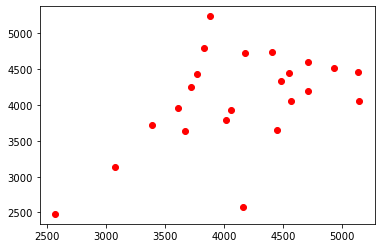

In [204]:
# do validation and plot the results
from sklearn.metrics import r2_score

pred = []
real = []

for i, (x,y) in enumerate(test_loader):
    real_yield = y.item()
    pred_yield = model(x).item()
    
    pred.append(pred_yield)
    real.append(real_yield)

pred = dataset.inverse_scalery(np.asarray(pred))
real = dataset.inverse_scalery(np.asarray(real))

r_squared = r2_score(real, pred)

print(f"the calculated r-squared value of the model is {r_squared}")

plt.plot(real, pred, 'ro')
plt.show()

export_df = pd.DataFrame(np.array([pred, real]).reshape(-1, 2), columns = ("pred_kgha", "real_kgha"))
export_df.to_csv("E:/data/crop-yield-prediction-rs/NN_predyield.csv")
        


In [12]:
# # Hyper-parameters 
input_size = len(train_loader)
hidden_size = 500 
num_epochs = 2
batch_size = 100
learning_rate = 0.001

model = NeuralNet(input_size, hidden_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        
        # origin shape: [5, 90]
        # resized: [5, 90]
        images = images.to(device)

#         images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')



TypeError: __init__() missing 1 required positional argument: 'out_features'

In [7]:
# # Test the model
# # In test phase, we don't need to compute gradients (for memory efficiency)
# with torch.no_grad():
#     n_correct = 0
#     n_samples = 0
#     for images, labels in test_loader:
#         images = images.reshape(-1, 90).to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         # max returns (value ,index)
#         _, predicted = torch.max(outputs.data, 1)
#         n_samples += labels.size(0)
#         n_correct += (predicted == labels).sum().item()

#     acc = 100.0 * n_correct / n_samples
#     print(f'Accuracy of the network on the 10000 test images: {acc} %')

RuntimeError: mat1 dim 1 must match mat2 dim 0